### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

1) MSE: $\frac{\partial L}{\partial F} = -2 * (y_i - a(x_i))$

MSE target $(x_i, 2 * (y_i - a(x_i)))$

2) Exponential: $\frac{\partial L}{\partial L} = - y_i * exp^{-a(x_i) * y_i}$

Exponential target $(x_i, y_i * exp^{-a(x_i) * y_i})$

3) Binominal deviance / Cross-entropy: $\frac{\partial L}{\partial F} = \frac{-y_i}{1 + exp ^ {a(x_i * y_i)}}$ 

Binominal deviance / Cross-entropy target $(x_i, \frac{y_i}{1 + exp ^ {a(x_i * y_i)}})$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import copy

In [ ]:
SEED = 15
np.random.seed(SEED)

In [ ]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=1e-1, n_estimators=100, colsample=1., subsample=1., random_state=15, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.model_ensemble = []
        self.feature_idx = []
        self.random_state=random_state
        pass
    
    def losses_target_definition(self):
        if(self.loss == 'MSE'):
            return lambda a, y: 2 * (y - a)
        elif(self.loss == 'Exponential'):
            return lambda a, y: y * np.exp(-a * y)
        elif(self.loss == 'Deviance'):
            return lambda a, y: y / (1 + np.exp(a * y))

    def modify_data(self, Y, to_train = 1):
        if(np.unique(Y) == np.array([0, 1])):
            if(to_train):
                return (Y - 0.5) * 2
            else:
                return (Y + 1) // 2

    def fit(self, X, y_orig, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.base_model = base_model
        self.init_model = init_model
        self.target_func = self.losses_target_definition()
        self.bin_task = False
        y = copy.deepcopy(y_orig)
        if(len(np.unique(y)) == 2):
            self.bin_task = True
            idx_0 = np.where(y == 0)
            y[idx_0] = -1
            idx_1 = np.where(y == 1)
            idx_1 = 1

        if(init_model is None):
            f = np.zeros(X.shape[0])
        else:
            init_model_clf = init_model()
            init_model_clf.fit(X, y)
            f = init_model_clf.predict(X)
        for i in range(self.n_estimators):
            cur_sample_idx = np.random.choice(np.arange(X.shape[0]), size=round(X.shape[0] * self.colsample), replace=False)
            cur_feature_idx = np.random.choice(np.arange(X.shape[1]), size=round(X.shape[1] * self.subsample), replace=False)
            self.feature_idx.append(cur_feature_idx)
            X_cur = X[np.ix_(cur_sample_idx, cur_feature_idx)]
            Y_modified_cur = y[cur_sample_idx]
            Y_antigrad = self.target_func(f[cur_sample_idx], Y_modified_cur)
            cur_model = self.base_model(*self.args, **self.kwargs, random_state=self.random_state)
            cur_model.fit(X_cur, Y_antigrad)
            f[cur_sample_idx] += self.learning_rate * cur_model.predict(X_cur)
            self.model_ensemble.append(cur_model)
        pass
        
    def predict(self, X):
        if(self.init_model is None):
            f0 = np.zeros(X.shape[0])
        else:
            f0 = np.asarray(self.init_model.predict(X))
        f =  np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            f += self.model_ensemble[i].predict(X[:, self.feature_idx[i]])
        f *= self.learning_rate
        f += f0
        f = f.round()
        if(self.bin_task):
            f[f >= 0] = 1
            f[f < 0] = 0
        return f

In [ ]:
my_clf = MyGradientBoostingClassifier(random_state=SEED)
clf = GradientBoostingClassifier(random_state=SEED)

In [ ]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target, random_state=SEED)

In [ ]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import fetch_california_housing


In [ ]:
def process_res(y):
    return (y > 2.0).astype(int)

In [ ]:
X, y = fetch_california_housing(return_X_y=True)
# Превращаем регрессию в классификацию
y = process_res(y)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [ ]:
opti_params = {
        'MSE': {
            "n_estimators": 4,
            "learning_rate": 1e-1,
            "subsample": 1.0,
            "colsample": 1.0,
        },
        'Exponential' : {
            "n_estimators": 4,
            "learning_rate": 1e-1,
            "subsample": 1.0,
            "colsample": 1.0,
        },
        'Deviance': {
            "n_estimators": 4,
            "learning_rate": 1e-1,
            "subsample": 1.0,
            "colsample": 1.0,
        },

    }

In [ ]:
def validation_score(my_clf, X, y, random_state=3, num_split=4, base_model=DecisionTreeRegressor, *args, **kwargs):
    skf = StratifiedKFold(n_splits=num_split, shuffle=True, random_state=random_state)
    scores = []
    for train_index, test_index in tqdm(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        my_clf.fit(X_train, y_train,base_model=base_model)
        y_predictions = my_clf.predict(X_test)
        cur_score = accuracy_score(y_pred=y_predictions, y_true=y_test)
        scores.append(cur_score)
    return sum(scores) / len(scores)

In [ ]:
scores_history = {
    'MSE': [],
    'Exponential' : [],
    'Deviance': []
}

number_of_estimators = np.arange(20, 160, 20)
num_split = 4
for cur_loss in scores_history:
    for cur_num_estimators in number_of_estimators:
        my_clf = MyGradientBoostingClassifier(random_state=SEED, n_estimators=cur_num_estimators, loss=cur_loss)
        cur_score = validation_score(my_clf=my_clf, X=X, y=y, random_state=SEED, num_split=num_split)
        scores_history[cur_loss].append(cur_score)

4it [00:11,  2.84s/it]
4it [00:21,  5.46s/it]
4it [00:36,  9.17s/it]
4it [00:43, 10.91s/it]
4it [00:45, 11.29s/it]
4it [00:45, 11.41s/it]
4it [00:45, 11.47s/it]
4it [00:12,  3.01s/it]
4it [00:23,  5.82s/it]
4it [00:34,  8.56s/it]
4it [00:44, 11.25s/it]
4it [00:56, 14.09s/it]
4it [01:06, 16.58s/it]
4it [01:16, 19.24s/it]
4it [00:11,  2.85s/it]
4it [00:22,  5.71s/it]
4it [00:33,  8.45s/it]
4it [00:44, 11.17s/it]
4it [00:56, 14.06s/it]
4it [01:06, 16.62s/it]
4it [01:16, 19.23s/it]


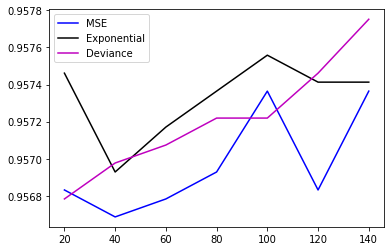

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

ax.plot(number_of_estimators, scores_history['MSE'], color='b',label='MSE')
ax.plot(number_of_estimators, scores_history['Exponential'], color='k', label='Exponential')
ax.plot(number_of_estimators, scores_history['Deviance'], color='m', label='Deviance')

plt.legend(loc=2)
plt.draw()


In [ ]:
for cur_loss in opti_params.keys():
    max_val = max(scores_history[cur_loss])
    idx_max = np.argmax(np.array(scores_history[cur_loss]))
    best_param_val = number_of_estimators[idx_max]
    opti_params[cur_loss]['n_estimators'] = best_param_val
    print('loss - {0}, parameters - {1}: score: {2}'.format(cur_loss, opti_params[cur_loss], max_val))

loss - MSE, parameters - {'n_estimators': 100, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample': 1.0}: score: 0.9573643410852714
loss - Exponential, parameters - {'n_estimators': 100, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample': 1.0}: score: 0.9575581395348838
loss - Deviance, parameters - {'n_estimators': 140, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample': 1.0}: score: 0.9577519379844961


In [ ]:
'''
В качестве гиперпараметров подбираются:
- learning rate
- colsample
- subsample
Рассматриваются все вариации с loss-ми
Гиперпараметер number_of_estimators уже подобран для разных конфигураций с loss-ми
'''

'\nВ качестве гиперпараметров подбираются:\n- learning rate\n- colsample\n- subsample\nРассматриваются все вариации с loss-ми\nГиперпараметер number_of_estimators уже подобран для разных конфигураций с loss-ми\n'

In [ ]:
def grid_search(opti_parameter, optimization_grid, opti_params, X, y, random_state=3):

    scores_history = {
        'MSE': [],
        'Exponential' : [],
        'Deviance': []
    }

    for cur_loss in opti_params.keys():
        for cur_opt_parameter in optimization_grid:
            opti_params[cur_loss][opti_parameter] = cur_opt_parameter
            my_clf = MyGradientBoostingClassifier(random_state=SEED, 
                                                  n_estimators=opti_params[cur_loss]['n_estimators'],
                                                  learning_rate=opti_params[cur_loss]['learning_rate'],
                                                  subsample=opti_params[cur_loss]['subsample'],
                                                  colsample=opti_params[cur_loss]['colsample'])
            cur_score = validation_score(my_clf=my_clf, X=X, y=y, random_state=random_state)
            scores_history[cur_loss].append(cur_score)

    return scores_history

In [ ]:
cur_opti_parameter = 'learning_rate'
optimization_grid = np.linspace(1e-4, 1., num=20)
lr_history = grid_search(opti_parameter=cur_opti_parameter, optimization_grid=optimization_grid, opti_params=opti_params, X=X, y=y, random_state=SEED)
for cur_loss in opti_params.keys():
    max_val = max(lr_history[cur_loss])
    idx_max = np.argmax(np.array(lr_history[cur_loss]))
    best_lr = optimization_grid[idx_max]
    opti_params[cur_loss][cur_opti_parameter] = best_lr
    print('loss - {0}, parameters - {1}: score: {2}'.format(cur_loss, opti_params[cur_loss], max_val))

4it [01:01, 15.34s/it]
4it [00:53, 13.46s/it]
4it [00:43, 10.84s/it]
4it [00:27,  6.90s/it]
4it [00:19,  4.86s/it]
4it [00:14,  3.64s/it]
4it [00:11,  2.82s/it]
4it [00:08,  2.23s/it]
4it [00:07,  1.75s/it]
4it [00:05,  1.26s/it]
4it [00:05,  1.29s/it]
4it [00:06,  1.75s/it]
4it [00:08,  2.21s/it]
4it [00:11,  2.83s/it]
4it [00:14,  3.64s/it]
4it [00:19,  4.94s/it]
4it [00:27,  6.89s/it]
4it [00:43, 10.82s/it]
4it [00:53, 13.46s/it]
4it [00:53, 13.39s/it]
4it [01:01, 15.31s/it]
4it [00:53, 13.49s/it]
4it [00:42, 10.69s/it]
4it [00:27,  6.84s/it]
4it [00:19,  4.86s/it]
4it [00:14,  3.64s/it]
4it [00:11,  2.83s/it]
4it [00:08,  2.22s/it]
4it [00:06,  1.75s/it]
4it [00:05,  1.26s/it]
4it [00:05,  1.27s/it]
4it [00:07,  1.76s/it]
4it [00:09,  2.39s/it]
4it [00:11,  2.83s/it]
4it [00:14,  3.64s/it]
4it [00:19,  4.89s/it]
4it [00:27,  6.86s/it]
4it [00:44, 11.23s/it]
4it [00:53, 13.39s/it]
4it [00:52, 13.21s/it]
4it [01:26, 21.66s/it]
4it [01:15, 18.77s/it]
4it [00:43, 10.80s/it]
4it [00:27,

loss - MSE, parameters - {'n_estimators': 100, 'learning_rate': 0.2632315789473684, 'subsample': 1.0, 'colsample': 1.0}: score: 0.9582364341085271
loss - Exponential, parameters - {'n_estimators': 100, 'learning_rate': 0.4737368421052632, 'subsample': 1.0, 'colsample': 1.0}: score: 0.9579941860465117
loss - Deviance, parameters - {'n_estimators': 140, 'learning_rate': 0.5263631578947369, 'subsample': 1.0, 'colsample': 1.0}: score: 0.958139534883721


In [ ]:
cur_opti_parameter = 'subsample'
optimization_grid = np.linspace(0.5, 1., num=20)
subsample_history = grid_search(opti_parameter=cur_opti_parameter, optimization_grid=optimization_grid, opti_params=opti_params, X=X, y=y, random_state=SEED)
for cur_loss in opti_params.keys():
    max_val = max(lr_history[cur_loss])
    idx_max = np.argmax(np.array(subsample_history[cur_loss]))
    best_param_val = optimization_grid[idx_max]
    opti_params[cur_loss][cur_opti_parameter] = best_param_val
    print('loss - {0}, parameters - {1}: score: {2}'.format(cur_loss, opti_params[cur_loss], max_val))

4it [00:08,  2.01s/it]
4it [00:08,  2.03s/it]
4it [00:07,  1.96s/it]
4it [00:09,  2.38s/it]
4it [00:09,  2.37s/it]
4it [00:09,  2.35s/it]
4it [00:09,  2.37s/it]
4it [00:09,  2.41s/it]
4it [00:11,  2.97s/it]
4it [00:11,  2.79s/it]
4it [00:11,  2.77s/it]
4it [00:11,  2.77s/it]
4it [00:12,  3.22s/it]
4it [00:12,  3.23s/it]
4it [00:12,  3.17s/it]
4it [00:12,  3.20s/it]
4it [00:12,  3.21s/it]
4it [00:14,  3.65s/it]
4it [00:14,  3.65s/it]
4it [00:14,  3.65s/it]
4it [00:03,  1.31it/s]
4it [00:03,  1.31it/s]
4it [00:03,  1.33it/s]
4it [00:03,  1.12it/s]
4it [00:03,  1.14it/s]
4it [00:03,  1.15it/s]
4it [00:03,  1.14it/s]
4it [00:03,  1.14it/s]
4it [00:03,  1.01it/s]
4it [00:03,  1.02it/s]
4it [00:03,  1.02it/s]
4it [00:03,  1.00it/s]
4it [00:04,  1.12s/it]
4it [00:04,  1.12s/it]
4it [00:04,  1.13s/it]
4it [00:04,  1.14s/it]
4it [00:04,  1.14s/it]
4it [00:05,  1.27s/it]
4it [00:05,  1.29s/it]
4it [00:05,  1.27s/it]
4it [00:03,  1.17it/s]
4it [00:03,  1.14it/s]
4it [00:03,  1.15it/s]
4it [00:04,

loss - MSE, parameters - {'n_estimators': 100, 'learning_rate': 0.2632315789473684, 'subsample': 0.5263157894736842, 'colsample': 1.0}: score: 0.9582364341085271
loss - Exponential, parameters - {'n_estimators': 100, 'learning_rate': 0.4737368421052632, 'subsample': 0.7894736842105263, 'colsample': 1.0}: score: 0.9579941860465117
loss - Deviance, parameters - {'n_estimators': 140, 'learning_rate': 0.5263631578947369, 'subsample': 0.8421052631578947, 'colsample': 1.0}: score: 0.958139534883721


In [ ]:
cur_opti_parameter = 'colsample'
optimization_grid = np.linspace(0.5, 1., num=20)
colsample_history = grid_search(opti_parameter=cur_opti_parameter, optimization_grid=optimization_grid, opti_params=opti_params, X=X, y=y, random_state=SEED)
for cur_loss in opti_params.keys():
    max_val = max(lr_history[cur_loss])
    idx_max = np.argmax(np.array(colsample_history[cur_loss]))
    best_param_val = optimization_grid[idx_max]
    opti_params[cur_loss][cur_opti_parameter] = best_param_val
    print('loss - {0}, parameters - {1}: score: {2}'.format(cur_loss, opti_params[cur_loss], max_val))

4it [00:14,  3.52s/it]
4it [00:13,  3.45s/it]
4it [00:14,  3.55s/it]
4it [00:13,  3.44s/it]
4it [00:13,  3.43s/it]
4it [00:13,  3.35s/it]
4it [00:13,  3.40s/it]
4it [00:13,  3.36s/it]
4it [00:13,  3.34s/it]
4it [00:13,  3.30s/it]
4it [00:12,  3.23s/it]
4it [00:12,  3.21s/it]
4it [00:12,  3.11s/it]
4it [00:12,  3.12s/it]
4it [00:12,  3.02s/it]
4it [00:11,  2.90s/it]
4it [00:11,  2.87s/it]
4it [00:10,  2.69s/it]
4it [00:10,  2.56s/it]
4it [00:08,  2.02s/it]
4it [00:08,  2.11s/it]
4it [00:08,  2.13s/it]
4it [00:08,  2.10s/it]
4it [00:08,  2.11s/it]
4it [00:09,  2.30s/it]
4it [00:08,  2.09s/it]
4it [00:08,  2.09s/it]
4it [00:08,  2.06s/it]
4it [00:08,  2.05s/it]
4it [00:08,  2.06s/it]
4it [00:07,  1.97s/it]
4it [00:07,  1.97s/it]
4it [00:07,  1.92s/it]
4it [00:07,  1.93s/it]
4it [00:07,  1.87s/it]
4it [00:07,  1.82s/it]
4it [00:06,  1.72s/it]
4it [00:06,  1.61s/it]
4it [00:05,  1.41s/it]
4it [00:04,  1.01s/it]
4it [00:10,  2.70s/it]
4it [00:11,  2.79s/it]
4it [00:10,  2.67s/it]
4it [00:10,

loss - MSE, parameters - {'n_estimators': 100, 'learning_rate': 0.2632315789473684, 'subsample': 0.5263157894736842, 'colsample': 0.8947368421052632}: score: 0.9582364341085271
loss - Exponential, parameters - {'n_estimators': 100, 'learning_rate': 0.4737368421052632, 'subsample': 0.7894736842105263, 'colsample': 1.0}: score: 0.9579941860465117
loss - Deviance, parameters - {'n_estimators': 140, 'learning_rate': 0.5263631578947369, 'subsample': 0.8421052631578947, 'colsample': 1.0}: score: 0.958139534883721


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
def process_res(y):
    return (y > 2.0).astype(int)

In [ ]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)
# Превращаем регрессию в классификацию
y = process_res(y)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [ ]:
from tqdm import tqdm

scores_history = {
    'MSE': [],
    'Exponential' : [],
    'Deviance': []
}

num_split = 4
for cur_loss in tqdm(scores_history):
    my_clf = MyGradientBoostingClassifier(random_state=SEED, loss=cur_loss, n_estimators=15)
    cur_score = validation_score(my_clf=my_clf, X=X, y=y, random_state=SEED, num_split=num_split, base_model=RandomForestRegressor)
    scores_history[cur_loss].append(cur_score)
print(scores_history)

  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [03:18, 198.09s/it]
2it [06:39, 200.08s/it]
3it [10:00, 200.51s/it]
4it [13:21, 200.48s/it]
 33%|███▎      | 1/3 [13:21<26:43, 801.95s/it]
0it [00:00, ?it/s]
1it [03:16, 196.87s/it]
2it [06:23, 190.94s/it]
3it [09:32, 189.79s/it]
4it [12:42, 190.58s/it]
 67%|██████▋   | 2/3 [26:04<12:58, 778.64s/it]
0it [00:00, ?it/s]
1it [03:04, 184.51s/it]
2it [06:09, 184.86s/it]
3it [09:18, 186.75s/it]
4it [12:24, 186.18s/it]
100%|██████████| 3/3 [38:34<00:00, 771.55s/it]

{'MSE': [0.9649709302325582], 'Exponential': [0.9586240310077518], 'Deviance': [0.8644379844961241]}


In [ ]:
scores_history = {
    'MSE': [],
    'Exponential' : [],
    'Deviance': []
}

num_models = 1
num_split = 4

for cur_loss in scores_history:
    skf = StratifiedKFold(n_splits=num_split, shuffle=True, random_state=SEED)
    scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_predictions = np.zeros((y_test.shape[0], num_models))
        for i in range(num_models):
            my_clf = MyGradientBoostingClassifier(random_state=SEED, loss=cur_loss)
            
            cur_idxs = np.random.choice(np.arange(X_train.shape[0]), round(X_train.shape[0]/num_models), replace=False)

            X_train_cur = X_train[cur_idxs]
            y_train_cur = y_train[cur_idxs]

            my_clf.fit(X_train_cur, y_train_cur)
            y_prediction_cur = my_clf.predict(X_test)
            y_predictions[:, i] = y_prediction_cur
        y_predictions_mod = np.apply_along_axis(np.bincount, 1, np.array(y_predictions, dtype=np.int64), minlength=len(np.unique(y)))
        y_predictions_mod = np.apply_along_axis(np.argmax, 1, y_predictions_mod)
        scores.append(accuracy_score(y_pred=y_predictions_mod, y_true=y_test))
    scores_history[cur_loss] = np.array(scores).mean()
scores_history

{'Deviance': 0.834156976744186,
 'Exponential': 0.8338662790697674,
 'MSE': 0.8315891472868218}

Результат не стал лучше. В случае с RandomForest думаю, что необходимо настраивать параметры.
В случае с усреднием результатов по бустингам. Изначально бустинг работает так, что variance не очень большой, а bias - да. Как я понимаю, при таком подходе могут быть проблемы с variance дополнительные.

*Я сократил число алгоритмов с RandomForest до 15, так как иначе у меня вылетало*

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [ ]:
scores_history = {
    'MSE': [],
    'Exponential' : [],
    'Deviance': []
}

num_split = 4
for cur_loss in scores_history:
    my_clf = MyGradientBoostingClassifier(random_state=SEED, loss=cur_loss)
    cur_score = validation_score(my_clf=my_clf, X=X, y=y, random_state=SEED, num_split=num_split, init_model=SVR, process_res=process_res)
    scores_history[cur_loss].append(cur_score)
print(scores_history)

4it [00:45, 11.33s/it]
4it [00:55, 13.96s/it]
4it [00:55, 13.94s/it]

{'MSE': [0.9575581395348838], 'Exponential': [0.9571220930232558], 'Deviance': [0.9576065891472868]}


In [ ]:
scores_history = {
    'MSE': [],
    'Exponential' : [],
    'Deviance': []
}

num_split = 4
for cur_loss in scores_history:
    my_clf = MyGradientBoostingClassifier(random_state=SEED, loss=cur_loss)
    cur_score = validation_score(my_clf=my_clf, X=X, y=y, random_state=SEED, num_split=num_split, init_model=SVR)
    scores_history[cur_loss].append(cur_score)
print(scores_history)

4it [00:48, 12.21s/it]
4it [00:56, 14.22s/it]
4it [00:56, 14.21s/it]

{'MSE': [0.9568798449612403], 'Exponential': [0.9574127906976744], 'Deviance': [0.9576065891472868]}


In [ ]:
scores_history = {
    'MSE': [],
    'Exponential' : [],
    'Deviance': []
}

num_split = 4
for cur_loss in scores_history:
    my_clf = MyGradientBoostingClassifier(random_state=SEED, loss=cur_loss)
    cur_score = validation_score(my_clf=my_clf, X=X, y=y, random_state=SEED, num_split=num_split, init_model=LinearRegression)
    scores_history[cur_loss].append(cur_score)
print(scores_history)

4it [00:45, 11.47s/it]
4it [00:56, 14.08s/it]
4it [00:55, 13.97s/it]

{'MSE': [0.9571705426356589], 'Exponential': [0.9573158914728682], 'Deviance': [0.9571705426356589]}


Результат не стал лучше. Думаю, что необходимо настраивать init_model.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

